# Recommended - Run on kaggle kernel as most used packages come ready

In [1]:
pip install resnest --pre

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Requirements
!pip install audiomentations[extras] --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=3ae452533fa670d5aaf08d23853633f8d0f0546478ad51347569efbd3acc6637
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 843 kB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=0e4c8d07a0b8944c5735dde7d8bb425724a2070ecca951b9222e007ca195b12d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
!pip install torchlibrosa

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

import cv2
import IPython.display as ipd
import librosa
import pydub
import soundfile
import audiomentations
import albumentations
from albumentations.pytorch import ToTensor

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms, utils
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup

import os
import warnings
import time
import copy
import random

from torchlibrosa.augmentation import SpecAugmentation

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [7]:
# !apt-get install ffmpeg

In [8]:
SEED = 42

In [9]:
def random_seed(SEED = SEED):    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
random_seed()

In [11]:
# update pytorch, torchvision, PIL/pillow

In [12]:
import PIL
PIL.__version__

'7.2.0'

In [13]:
import torch
torch.__version__

'1.6.0'

In [14]:
# df_train = pd.read_csv("data/Train.csv")
# sample_submission = pd.read_csv("data/SampleSubmission.csv")
# df_test = sample_submission[["fn"]].copy()

df_train = pd.read_csv("../input/giz-data/giz_data/Train.csv")
sample_submission = pd.read_csv("../input/giz-data/giz_data/SampleSubmission.csv")

In [15]:
ORIGINAL_AUDIO_PATH = "../input/giz-data/giz_data/audio_files/"
# Named AdditionalUtterances
ADDITIONAL_AUDIO_PATH_1 = "../input/giz-data/AdditionalUtterancesConverted/AdditionalUtterancesConverted/"
ADDITIONAL_AUDIO_PATH_2 = "../input/giz-data/AdditionalUtterancesConverted_2/AdditionalUtterancesConverted_2/"

In [16]:
# match fnames in dataframes to audio path
df_train["fn"] = df_train.fn.str.replace("audio_files/", ORIGINAL_AUDIO_PATH)
sample_submission["fn"] = sample_submission.fn.str.replace("audio_files/", ORIGINAL_AUDIO_PATH)

In [17]:
df_test = sample_submission[["fn"]].copy()

In [18]:
df_train["fold"] = -1

In [19]:
# sss = StratifiedShuffleSplit(n_splits = 5, random_state = SEED, test_size = 0.2)
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = SEED)

for fold, (train_idx, valid_idx) in enumerate(kfold.split(df_train, df_train.label.values)):
    
#     df_train.loc[valid_idx, "fold"] = df_train.loc[valid_idx, "fold"].apply(lambda row: fold + 1 if row == -1 else row)
    df_train.loc[valid_idx, "fold"] = fold + 1 

In [20]:
df_train.fold.value_counts()

2    370
1    370
3    369
Name: fold, dtype: int64

In [21]:
# Porblems with additional audio data like similar voicings/duplicates, sr was initially different, file type was initially mp3
df_train["weight"] = 0.65

### Add additional audio details to existing dataframe

In [22]:
base_path_1 = ADDITIONAL_AUDIO_PATH_1 + "latest_keywords"
additional_labels_1 = os.listdir(base_path_1)

base_path_2 = ADDITIONAL_AUDIO_PATH_2 + "nlp_keywords"
additional_labels_2 = os.listdir(base_path_2)

In [23]:
new_fns = []
new_labels = []
# batch = []

In [24]:
for label in additional_labels_1:
    samples_in_label = os.listdir(os.path.join(base_path_1, label))
    
    for sample in samples_in_label:
        file_path = os.path.join(base_path_1, label + "/" + sample)
        new_fns.append(file_path)
        new_labels.append(label)
#         batch.append(1)

        
for label in additional_labels_2:
    samples_in_label = os.listdir(os.path.join(base_path_2, label))
    
    for sample in samples_in_label:
        file_path = os.path.join(base_path_2, label + "/" + sample)
        new_fns.append(file_path)
        new_labels.append(label) 
#         batch.append(2)

In [25]:
df_new = np.asarray([new_fns, new_labels]).T
# df_new_ = np.reshape(df_new_, (-1, 2))
df_new = pd.DataFrame(df_new, columns = ["fn", "label"])

# df_new["batch"] = batch

In [26]:
# df_new["id_"] = df_new.fn.apply(lambda row: row.split("/")[-1].split("_")[0])
# to_keep = df_new[["label", "id_"]].drop_duplicates().index
# df_new = df_new.iloc[to_keep].reset_index(drop = True)
# df_new = df_new.drop("id_", axis = 1)

In [27]:
# df_new["id_"] = df_new.fn.apply(lambda row: row.split("/")[-1].split("_")[0])
# to_keep = df_new[df_new.batch == 1][["label", "id_"]].drop_duplicates().index.append(df_new[df_new.batch == 2].index)
# df_new = df_new.iloc[to_keep].reset_index(drop = True)
# df_new = df_new.drop("id_", axis = 1)

In [28]:
# Use all for training - identified by -1
df_new["fold"] = -1

In [29]:
df_new["weight"] = 0.35

In [30]:
df_train.shape, df_new.shape

((1109, 4), (3600, 4))

## New df to be used for training

In [31]:
# Concat
df_train_new = pd.concat([df_train, df_new], axis = 0).reset_index(drop = True)

In [32]:
# Sort
df_train_new = df_train_new.sort_values("label").reset_index(drop = True)
# Shuffle
df_train_new = df_train_new.sample(frac=1, random_state = 42).reset_index(drop = True)

In [33]:
# df_train_new = df_train.copy()

In [34]:
df_train_new.shape, df_test.shape

((4709, 4), (1017, 1))

In [35]:
df_train_new.head()

,fn,label,fold,weight
0,../input/giz-data/AdditionalUtterancesConverte...,ebiwuka,-1,0.35
1,../input/giz-data/AdditionalUtterancesConverte...,ekitooke,-1,0.35
2,../input/giz-data/AdditionalUtterancesConverte...,nakavundira,-1,0.35
3,../input/giz-data/AdditionalUtterancesConverte...,obumonde,-1,0.35
4,../input/giz-data/AdditionalUtterancesConverte...,obusaanyi,-1,0.35


### Sample an audio

In [ ]:
sample = '../input/giz-data/giz_data/audio_files/00118N3.wav'
ipd.Audio(sample)

In [ ]:
sample = '../input/giz-data/AdditionalUtterancesConverted/AdditionalUtterancesConverted/latest_keywords/abalimi/5aa4893526794a73a3ed0a7ebba2a7bf_4b41e8fd3c364e5082d1b2b5bb64c8d9.wav'
y, sr = librosa.load(sample, sr = None, mono = True)
yt, index = librosa.effects.trim(y)
ipd.Audio(yt, rate = 22050)

In [ ]:
# get max number of samples i.e len(y) which signifies longest sound

In [ ]:
ipd.Audio(np.pad(y, (0, 9999)), rate = 22050)

In [ ]:
len(y), len(y) / 22050, librosa.get_duration(y)

In [ ]:
len(np.pad(y, (0, 1)))

## Encode targets

In [36]:
# Quick Label encoding
df_train_new["target"] = df_train_new.label.astype("category").cat.codes

In [ ]:
df_train["target"] = df_train.label.astype("category").cat.codes

## Util functions

In [ ]:
#https://github.com/TheoViel/kaggle_birdcall_identification/blob/master/src/data/transforms.py
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

#     # Standardize
#     mean = mean or X.mean()
#     std = std or X.std()
#     X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def normalize(image):
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    
    image = (image / 255.0).astype(np.float32)
    image = (image - MEAN) / STD
    return np.moveaxis(image, 2, 0)

In [37]:
#https://github.com/TheoViel/kaggle_birdcall_identification/blob/master/src/data/transforms.py
def mono_to_color(power, pcen, amp, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([power, pcen, amp], axis=-1)

#     # Standardize
#     mean = mean or X.mean()
#     std = std or X.std()
#     X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def normalize(image):
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    
    image = (image / 255.0).astype(np.float32)
    image = (image - MEAN) / STD
    return np.moveaxis(image, 2, 0)

In [ ]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [ ]:
# def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
#     # Stack X as [X,X,X]
#     X = np.stack([X, X, X], axis=-1)

#     # Standardize
#     mean = mean or X.mean()
#     X = X - mean
#     std = std or X.std()
#     Xstd = X / (std + eps)
#     _min, _max = Xstd.min(), Xstd.max()
#     norm_max = norm_max or _max
#     norm_min = norm_min or _min
#     if (_max - _min) > eps:
#         # Normalize to [0, 255]
#         V = Xstd
#         V[V < norm_min] = norm_min
#         V[V > norm_max] = norm_max
#         V = 255 * (V - norm_min) / (norm_max - norm_min)
#         V = V.astype(np.uint8)
#     else:
#         # Just zero
#         V = np.zeros_like(Xstd, dtype=np.uint8)
#     return V

In [38]:
def get_audio_transforms():
    random_seed()
    transforms = audiomentations.Compose(
        [
#             audiomentations.FrequencyMask(p = 0.5),
#             audiomentations.AddGaussianSNR(max_SNR = 0.5),
#             audiomentations.AddGaussianNoise(),
#             audiomentations.TimeStretch(p = 0.5, leave_length_unchanged = False),
#             audiomentations.PitchShift(p = 0.5),
#             audiomentations.Shift(p = 0.5),
            # Normalize sound levels
            audiomentations.Normalize(p = 1.0),
#             audiomentations.Trim(),
#             audiomentations.ClippingDistortion(),
# #             audiomentations.AddBackgroundNoise(sounds_path=BACKGROUND_PATH, min_snr_in_db=0, max_snr_in_db=2, p=0.5)
#             audiomentations.Gain(),
        ]
    )
    random_seed()
    return transforms

def get_audio_transforms2():
    random_seed()
    transforms = audiomentations.Compose(
        [
#             audiomentations.FrequencyMask(p = 0.5),
#             audiomentations.AddGaussianSNR(max_SNR = 0.25),
#             audiomentations.AddGaussianNoise(),
#             audiomentations.TimeStretch(leave_length_unchanged = False),
#             audiomentations.PitchShift(),
#             audiomentations.Shift(),
            # Normalize sound levels
            audiomentations.Normalize(p = 1.0),
#             audiomentations.Trim(),
#             audiomentations.ClippingDistortion(),
# #             audiomentations.AddBackgroundNoise(sounds_path=BACKGROUND_PATH, min_snr_in_db=0, max_snr_in_db=2, p=0.5)
#             audiomentations.Gain(),
        ]
    )
    random_seed()
    return transforms

In [ ]:
def get_image_transforms(train = True):
    
    needed_transforms =         [
            albumentations.Resize(224, 224),
            albumentations.Normalize(),
            ToTensor(),
    
    transforms = albumentations.Compose(
        [
            albumentations.Resize(224, 224),
            albumentations.Normalize(),
            ToTensor(),
            if train:
                albumentations.HorizontalFlip(),
#             albumentations.RandomBrightness(),
        #     albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
        #     albumentations.JpegCompression(80),
#             albumentations.HueSaturationValue(), 
            else:
                pass
        ]
    )
        
    return transforms

In [ ]:
mel_spect = librosa.feature.melspectrogram(wav, sr = sr, n_mels = 128, fmin = 20, fmax = sr / 2.0,)
mel_spect = librosa.power_to_db(mel_spect)        

In [ ]:
# 1 channel
mel_spect.shape

In [ ]:
# 3 channels 
mono_to_color(mel_spect).shape

## Data Class

In [ ]:
?torchaudio.transforms.FrequencyMasking

In [40]:
def get_mask_transforms():    
    mask_transforms = nn.Sequential(
#         torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=128),
        torchaudio.transforms.FrequencyMasking(freq_mask_param = 16),
        torchaudio.transforms.TimeMasking(time_mask_param = 32)
#         torchaudio.transforms.TimeStretch(p)
#         torchaudio.transforms.FrequencyMasking(),
#         torchaudio.transforms.TimeMasking()
    )
    
    return mask_transforms

In [ ]:
# ?librosa.feature.melspectrogram
?librosa.amplitude_to_db

In [ ]:
SAMPLING_RATE = 22050

In [ ]:
yy, srr = librosa.load(df_train_new.fn[1234], sr = None, mono = True)

In [ ]:
ipd.Audio(yy, rate = 22050)

In [ ]:
df_train_new.fn[123]

In [ ]:
df_train_new.fn[99]

In [ ]:
len(yy) / 22050

In [ ]:
class MelspectrogramData(Dataset):
    def __init__(self, df, audio_transforms = None, image_transforms = None, mask_transforms = None, train = True, visualization = False, sr = None):
        self.df = df  
        self.audio_files = df.fn.values
        # Train time audio and image augmentation
        self.audio_transforms = audio_transforms
        self.image_transforms = image_transforms 
        self.mask_transforms = mask_transforms
        self.train = train
        self.visualization = visualization
        self.sr = sr
        
        if train:
            self.targets = self.df.target
            self.weights = self.df.weight
        if visualization:
            self.labels = self.df.label
    
    def __len__(self):
        return len(self.df)
    
    def get_mel_spect(self, y, sr):
        mel_spect = librosa.feature.melspectrogram(
            y, sr = sr, n_mels = 128, fmin = 20, fmax = sr // 2.0, n_fft = 2048, hop_length = 512,
        )

        mel_spect = librosa.power_to_db(mel_spect)
#         mel_spect = librosa.amplitude_to_db(mel_spect)
        
        return mel_spect

    def __getitem__(self, idx):
        # y == wav filfe
        sr = self.sr
        train = self.train
        visualization = self.visualization
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)

            y, sr = librosa.load(self.audio_files[idx], sr = self.sr, mono = True, res_type = "kaiser_fast")
#             y, sr = librosa.core.audio.load(self.audio_files[idx])
#             y = librosa.to_mono(y)
#             if sr != SAMPLING_RATE:
#                 y = librosa.resample(y, sr, SAMPLING_RATE, res_type = 'kaiser_fast')
#             y, _ = librosa.effects.trim(y)
    #         y, sr = soundfile.read(self.audio_files[idx])
    #         print(sr)

        if self.audio_transforms != None:
            # Apply audio augmentations (to train)
            y = self.audio_transforms(samples = y, sample_rate = sr)

        mel_spect = self.get_mel_spect(y, sr)
        
        if self.mask_transforms != None:
            # Applied to mel (spect)
            mel_spect = self.mask_transforms(torch.tensor(mel_spect))

        img = mono_to_color(mel_spect)
#         img = spec_to_image(mel_spect)
#         img = normalize(img)
        
    
            
#         img = spec_to_image(mel_spect)
        # Apply image augmentations
        # specific train and test image transforms is specified later
#         img = Image.fromarray(img)
#         img = self.image_transforms(img)
        img = self.image_transforms(image = img)
#         img = self.image_transforms(image = mel_spect)
        
        if self.train:
        # Ensure no trnTAudioAugment. is applied to validation 
            if self.visualization:
                label = self.labels[idx]
                return {
                    "img": img,
                    "label": label                   
                }
            else:
                #Convert to tensor because needed for modelling operations using tensors
                target = torch.tensor(self.targets[idx], dtype = torch.long)
                weight = torch.tensor(self.weights[idx], dtype = torch.float16)
                return {
                    "img": img,
                    "target": target,
                    "weight": weight
                }
        else:
            return {
                "img": img
            }

        

In [ ]:
?SpecAugmentation

In [44]:
class MelspectrogramData(Dataset):
    def __init__(self, df, audio_transforms = None, image_transforms = None, mask_transforms = None, train = True, visualization = False, sr = None):
        self.df = df  
        self.audio_files = df.fn.values
        # Train time audio and image augmentation
        self.audio_transforms = audio_transforms
        self.image_transforms = image_transforms 
        self.mask_transforms = mask_transforms
        self.train = train
        self.visualization = visualization
        self.sr = sr
#         self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, freq_drop_width=8, freq_stripes_num=2)
        
        if train:
            self.targets = self.df.target
            self.weights = self.df.weight
        if visualization:
            self.labels = self.df.label
    
    def __len__(self):
        return len(self.df)
    
    def get_mel_spect(self, y, sr):
        mel_spect = librosa.feature.melspectrogram(
            y, sr = sr, n_mels = 128, fmin = 20, fmax = sr // 2.0, n_fft = 2048, hop_length = 512,
        )

#         mel_spect = librosa.power_to_db(mel_spect)
#         mel_spect = librosa.amplitude_to_db(mel_spect)
        
        return mel_spect

    def __getitem__(self, idx):
        # y == wav filfe
        sr = self.sr
        train = self.train
        visualization = self.visualization
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)

            y, sr = librosa.load(self.audio_files[idx], sr = self.sr, mono = True, res_type = "kaiser_fast")
#             y, sr = librosa.core.audio.load(self.audio_files[idx])
#             y = librosa.to_mono(y)
#             if sr != SAMPLING_RATE:
#                 y = librosa.resample(y, sr, SAMPLING_RATE, res_type = 'kaiser_fast')
#             y, _ = librosa.effects.trim(y)
    #         y, sr = soundfile.read(self.audio_files[idx])
    #         print(sr)

        if self.audio_transforms != None:
            # Apply audio augmentations (to train)
            y = self.audio_transforms(samples = y, sample_rate = sr)

        mel_spect = self.get_mel_spect(y, sr)
        
        power = librosa.power_to_db(mel_spect)
        pcen = librosa.pcen(mel_spect, sr = sr)
        amp = librosa.amplitude_to_db(mel_spect)
        
#         p = self.spec_augmenter(torch.tensor(power))
        
        if self.mask_transforms != None:
            # Applied to mel (spect)
#             mel_spect = self.mask_transforms(torch.tensor(mel_spect))
            power = self.mask_transforms(torch.tensor(power))
            pcen = self.mask_transforms(torch.tensor(pcen))
            amp = self.mask_transforms(torch.tensor(amp))           

        img = mono_to_color(power, pcen, amp)
#         img = spec_to_image(mel_spect)
#         img = normalize(img)
        
    
            
#         img = spec_to_image(mel_spect)
        # Apply image augmentations
        # specific train and test image transforms is specified later
#         img = Image.fromarray(img)
#         img = self.image_transforms(img)
        img = self.image_transforms(image = img)
#         img = self.image_transforms(image = mel_spect)
        
        if self.train:
        # Ensure no trnTAudioAugment. is applied to validation 
            if self.visualization:
                label = self.labels[idx]
                return {
                    "img": img,
                    "label": label                   
                }
            else:
                #Convert to tensor because needed for modelling operations using tensors
                target = torch.tensor(self.targets[idx], dtype = torch.long)
                weight = torch.tensor(self.weights[idx], dtype = torch.float16)
                return {
                    "img": img,
                    "target": target,
                    "weight": weight
                }
        else:
            return {
                "img": img
            }

        

## Vizualize some data

In [ ]:
?albumentations.Resize

In [42]:
def visualize_data(target_to_sample = "any"):
    assert target_to_sample == "any" or type(target_to_sample) == int
    
    if target_to_sample == "any":
        # Use all train data
        sample_df = df_train_new
    else:
        sample_df = df_train_new[df_train_new.target == target_to_sample].reset_index(drop = True)
        
    image_transforms = albumentations.Compose([
        albumentations.Resize(224, 224),
    #     albumentations.HorizontalFlip(),
    #     albumentations.RandomBrightness(),
    #     albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    #     albumentations.JpegCompression(80),
    #     albumentations.HueSaturationValue(),
#         albumentations.Normalize(mean=(0.5), std=(0.2)),
        albumentations.Normalize(),
        ToTensor()
    ])        
    
    sample_data = MelspectrogramData(sample_df, get_audio_transforms(), image_transforms, mask_transforms = get_mask_transforms(), visualization = True)
    sample_loader = DataLoader(sample_data, batch_size = 8, shuffle = True, num_workers = 0)
    
    sample_data_iter = iter(sample_loader)
    sample_output = sample_data_iter.next()
    sample_images = sample_output["img"]["image"].numpy()
    sample_labels = sample_output["label"]
    
    fig = plt.figure(figsize = (24, 8))

    for idx in np.arange(len(sample_images)):
        ax = fig.add_subplot(2, 8/2, idx + 1, xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample_images[idx]).transpose(1, 2, 0), cmap = "gray")
#         ax.imshow(np.squeeze(sample_images[idx]), cmap = "gray")
        ax.set_title(str(sample_labels[idx]))    

In [ ]:
# warnings.filterwarnings("ignore")

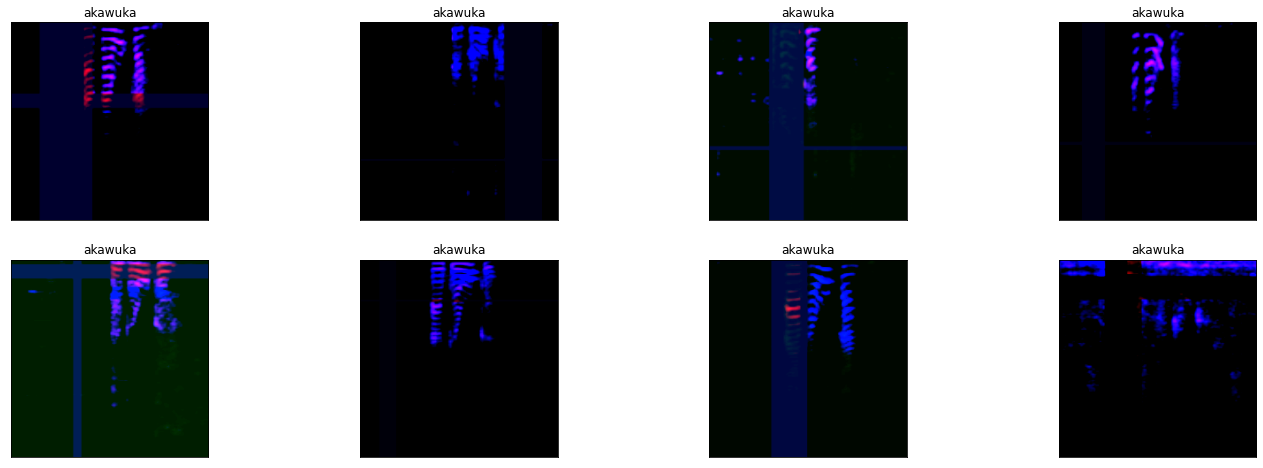

In [45]:
visualize_data(10)

In [ ]:
visualize_data(10)

In [ ]:
image_transforms_train = albumentations.Compose([
    albumentations.Resize(224, 224),
#     albumentations.HorizontalFlip(),
#     albumentations.RandomBrightness(),
#     albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
#     albumentations.JpegCompression(80),
#     albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    ToTensor()
    ])
image_transforms_test = albumentations.Compose([
    albumentations.Resize(512, 512),
    albumentations.Normalize(),
    ToTensor()
    ])

In [ ]:
# Use language as a feature, number of syllables, EDA
# df_train.label.unique()

In [46]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# device = xm.xla_device()
# torch.set_default_tensor_type('torch.FloatTensor')

In [47]:
from efficientnet_pytorch import EfficientNet
import pretrainedmodels
from resnest.torch import resnest50

In [ ]:
# model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

In [ ]:
nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 193)
)

In [ ]:
sum(p.numel() for p in get_model().parameters() if p.requires_grad)

In [ ]:
i = 1
for child in get_model().children():
    print(i)
    print(child)
    i += 1

In [ ]:
# put model into a model class?
# pass model name arg to get_model() function

In [ ]:
pretrainedmodels.model_names

In [ ]:
?models.resnext50_32x4d

In [ ]:
def get_model():
#     random_seed()
    model = models.resnext50_32x4d(pretrained=True)
#     model = models.resnet50(pretrained=True)
#     model = models.mobilenet_v2(pretrained = True)
#     model = models.wide_resnet50_2(pretrained = True)
#     model = resnest50(pretrained = True)
#     pretrainedmodels.se

#     print(model.fc.in_features)
    random_seed()
    in_features = model.fc.in_features
    #vgg
#     in_features = model.classifier[6].in_features
    # mobilenet
#     in_features = model.classifier[1].in_features

    random_seed()
    for p in model.parameters():
        random_seed()
        p.requires_grad = True
     
#     cc = 1
#     for child in model.children():    
#         if cc <= 6:
#             for param in child.parameters():
#                 param.requires_grad = False
#         cc += 1

#     random_seed()
#     model.fc = nn.Linear(in_features, 193)
#     nn.init.xavier_normal_(model.fc.weight)
#     torch.manual_seed(SEED)
#     model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#     model.conv1.weight = nn.Parameter(model.conv1.weight.sum(dim=1, keepdim=True))

#     model.avgpool = nn.AdaptiveMaxPool2d(output_size = (1, 1))
    model.fc = nn.Sequential(
#         nn.Dropout(0.5),
        nn.Linear(in_features, 193)
    )
    
#     model.classifier = nn.Sequential(
#         nn.Dropout(p=0.5, inplace = False),
#         nn.Linear(in_features, out_features = 193, bias=True)
#     ) 

#     model.classifier[6].out_features = 193
    
    
    
   

    return model

In [ ]:
get_model()

In [52]:
class ResNext(nn.Module):
    def __init__(self, base_model_name: str, pretrained=True,
                 num_classes=193):
        super().__init__()
        base_model = models.__getattribute__(base_model_name)(
            pretrained=pretrained)
        layers = list(base_model.children())[:-1]
#         layers = list(base_model.children())
#         layers.append(nn.AdaptiveMaxPool2d((1, 1)))
        self.encoder = nn.Sequential(*layers)

        in_features = base_model.fc.in_features

        self.classifier = nn.Sequential(
#             nn.Linear(in_features, 1024), nn.ReLU(), nn.Dropout(p=0.2),
#             nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
#             nn.Linear(1024, num_classes)
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        batch_size = x.size(0)
#         print(x.shape)
#         x = torch.mean(x, dim=1)
#         print(x.shape)
        x = self.encoder(x).view(batch_size, -1)
#         print(x.shape)
        x = self.classifier(x)
#         multiclass_proba = F.softmax(x, dim=1)
#         multilabel_proba = F.sigmoid(x)
#         return {
#             "logits": x,
#             "multiclass_proba": multiclass_proba,
#             "multilabel_proba": multilabel_proba
#         }
        return x

In [ ]:
torch.tensor([[1,2]]).shape

In [ ]:
ResNext("resnext50_32x4d")

In [ ]:
get_model()

In [ ]:
resnet34
resnext50_32x4d

dpn68b

In [ ]:
def get_model(model_name):
#     random_seed()
    model = pretrainedmodels.__dict__[model_name](pretrained = "imagenet+5k")
#     model = pretrainedmodels.__dict__[model_name](pretrained = "imagenet")
#     model = models.resnet34(pretrained=True)

#     print(model.fc.in_features)
#     random_seed()
    #dpn
    in_channels = model.last_linear.in_channels
    #dense
#     in_features = model.last_linear.in_features

#     random_seed()
#     for p in model.parameters():
#         random_seed()
#         p.requires_grad = True
        
    random_seed()
    for p in model.features[0:24].parameters():
        random_seed()
        #Freeze first 10 model.features layers
        p.requires_grad = False     

        
#     for m in model.modules():
#         if isinstance(m, nn.Conv2d):
#             nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
#             nn.init.constant_(m.weight, 1)
#             nn.init.constant_(m.bias, 0)    
        
    # main_module 
#     for child in model.children():
#         main_module = child
#         i = 1
#         for block in main_module:
#             # Dual Path Blocks
#             blocks.append(block)

#             if i <= 20:
#                 for param in block.parameters():
#                     param.requires_grad = False
                    
#                 del block
                
#             i += 1
            
#         # 2nd child consisting of last Conv Layer is not needed
#         break    
        
#     model.features = nn.Sequential(*list(model.features.children())[:-4])
    
#     cc = 1
#     for child in model.children():    
#         if cc <= 6:
#             for param in child.parameters():
#                 param.requires_grad = False
#         cc += 1

#     random_seed()
#     model.fc = nn.Linear(in_features, 193)
#     nn.init.xavier_normal_(model.fc.weight)
#     torch.manual_seed(SEED)
#     model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#     model.conv1.weight = nn.Parameter(model.conv1.weight.sum(dim=1, keepdim=True))

#     model.last_linear = nn.Sequential(
# #         nn.Dropout(0.5),
#         nn.Linear(in_features, 193)
#     )
    
    #dpn
#     model.last_linear = nn.Conv2d(in_channels, 193, kernel_size=(1, 1), stride=(1, 1))
    model.last_linear = nn.Sequential(
#         nn.Linear(in_features, out_features = 193, bias=True)
#         nn.Dropout2d(0.2),
        nn.Conv2d(in_channels, 193, kernel_size=(1, 1), stride=(2, 2)),
#         nn.AdaptiveAvgPool2d(output_size=(1, 1)),
#         nn.Linear(in_channels, out_features = 193, bias=True),
#         nn.AdaptiveAvgPool2d(output_size=(1, 1)),
#         nn.Linear(512, out_features = 193, bias = True)
    )    
#     dense
#     model.last_linear = nn.Linear(in_features, out_features = 193, bias=True)
    
    
    
   

    return model

In [ ]:
get_model("dpn68b").features

In [ ]:
?librosa.feature.melspectrogram

In [ ]:
m = pretrainedmodels.__dict__["dpn68b"]()#='imagenet+5k'
# m = pretrainedmodels.__dict__["se_resnext50_32x4d"]()
# m = models.vgg11_bn()

In [ ]:
m.last_linear

In [ ]:
# main_module 
blocks = []
for child in m.children():
    main_module = child
    i = 1
    for block in main_module:
        main_module.rem      
        # Dual Path Blocks
        blocks.append(block)
        
#         if i <= 24:
#             for param in block.parameters():
#                 param.requires_grad = True
    # 2nd child consisting of last Conv Layer is not needed

    break
len(blocks)

In [ ]:
blocks[-1]

In [ ]:
len(nn.Sequential(*list(m.features.children())[:-4]))

In [ ]:
m

In [ ]:
modules = []
for mi in m.modules():
    
#     print("**************************************")
    if isinstance(mi, nn.Conv2d):
        modules.append(mi)

In [ ]:
len(modules)

In [ ]:
modules[0]

In [ ]:
m.last_linear.in_features

In [ ]:
m.last_linear.in_channels

In [ ]:
get_model()

In [ ]:
get_model("se_resnet50")

In [ ]:
def get_model():
#     random_seed()
    model = EfficientNet.from_name('efficientnet-b0')

#     print(model.fc.in_features)
#     random_seed()
    in_features = model._fc.in_features

#     random_seed()
    for p in model.parameters():
        random_seed()
        p.requires_grad = True

#     random_seed()
    # model.fc = nn.Linear(in_features, 193)
#     torch.manual_seed(SEED)
    model._fc = nn.Sequential(
#         nn.Dropout(0.5),
        nn.Linear(in_features, 193)
    )

    return model

In [ ]:
random_seed()
model = models.resnet34(pretrained=True)

print(model.fc.in_features)
random_seed()
in_features = model.fc.in_features

random_seed()
for p in model.parameters():
    random_seed()
    p.requires_grad = True
    
random_seed()
# model.fc = nn.Linear(in_features, 193)
torch.manual_seed(SEED)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 193)
)

model

In [ ]:
model

In [ ]:
# model = models.resnet34(pretrained=True)
# model.fc = nn.Linear(512,50)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 4), stride=(1, 1), padding=(3, 3), bias=False)
# model = model.to(device)

model = EfficientNet.from_name('efficientnet-b0')
for p in model.parameters():
    p.requires_grad = True
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, 193)

In [ ]:
model = CustomNet()
# print(model)
model.to(device)

In [ ]:
?get_linear_schedule_with_warmup

In [ ]:
def focal_loss(labels, logits, alpha, gamma):
    """Compute the focal loss between `logits` and the ground truth `labels`.
    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class.
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).
    Args:
      labels: A float tensor of size [batch, num_classes].
      logits: A float tensor of size [batch, num_classes].
      alpha: A float tensor of size [batch_size]
        specifying per-example weight for balanced cross entropy.
      gamma: A float scalar modulating loss from hard and easy examples.
    Returns:
      focal_loss: A float32 scalar representing normalized total loss.
    """    
    BCLoss = F.binary_cross_entropy_with_logits(input = logits, target = labels,reduction = "none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 + 
            torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss

    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss



def CB_loss(labels, logits, samples_per_cls, no_of_classes, loss_type, beta, gamma):
    """Compute the Class Balanced Loss between `logits` and the ground truth `labels`.
    Class Balanced Loss: ((1-beta)/(1-beta^n))*Loss(labels, logits)
    where Loss is one of the standard losses used for Neural Networks.
    Args:
      labels: A int tensor of size [batch].
      logits: A float tensor of size [batch, no_of_classes].
      samples_per_cls: A python list of size [no_of_classes].
      no_of_classes: total number of classes. int
      loss_type: string. One of "sigmoid", "focal", "softmax".
      beta: float. Hyperparameter for Class balanced loss.
      gamma: float. Hyperparameter for Focal loss.
    Returns:
      cb_loss: A float tensor representing class balanced loss
    """
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes

    labels_one_hot = F.one_hot(labels, no_of_classes).float()

    weights = torch.tensor(weights).float()
    weights = weights.unsqueeze(0)
    weights = weights.repeat(labels_one_hot.shape[0],1) * labels_one_hot
    weights = weights.sum(1)
    weights = weights.unsqueeze(1)
    weights = weights.repeat(1,no_of_classes)

    if loss_type == "focal":
        cb_loss = focal_loss(labels_one_hot, logits, weights, gamma)
    elif loss_type == "sigmoid":
        cb_loss = F.binary_cross_entropy_with_logits(input = logits,target = labels_one_hot, weights = weights)
    elif loss_type == "softmax":
        pred = logits.softmax(dim = 1)
        cb_loss = F.binary_cross_entropy(input = pred, target = labels_one_hot, weight = weights)
    return cb_loss


In [ ]:
F.one_hot(torch.tensor(df_train_new.target, dtype = torch.long), 193)

In [ ]:
wd = MelspectrogramData(train_set, audio_transforms = get_audio_transforms(), image_transforms = train_transforms, mask_transforms = None, train = True, sr=None)

In [ ]:
for i in DataLoader(wd, batch_size = 32, shuffle = False, num_workers = 0):
    # 1st batch
    dd = i
    break

In [ ]:
labels = torch.zeros(193, dtype=torch.long)
cls = []
for target in F.one_hot(dd["target"], 193):
    labels += target
    cls.append(target)

In [ ]:
list(labels.numpy())

In [ ]:
def mixup_data(x, y, alpha=0.4):
    """
    Applies mixup to a sample
    Arguments:
        x {torch tensor} -- Input batch
        y {torch tensor} -- Labels
    Keyword Arguments:
        alpha {float} -- Parameter of the beta distribution (default: {0.4})
    Returns:
        torch tensor  -- Mixed input
        torch tensor  -- Labels of the original batch
        torch tensor  -- Labels of the shuffle batch
        float  -- Probability samples by the beta distribution
    """
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1

    index = torch.randperm(x.size()[0]).cuda()

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

In [ ]:
!pip install torchtoolbox

In [ ]:
from torchtoolbox.optimizer import Lookahead
from torchtoolbox.tools import mixup_data, mixup_criterion

In [ ]:
?mixup_criterion

In [ ]:
def do_mixup(x, mixup_lambda):
    """Mixup x of even indexes (0, 2, 4, ...) with x of odd indexes 
    (1, 3, 5, ...).
    Args:
      x: (batch_size * 2, ...)
      mixup_lambda: (batch_size * 2,)
    Returns:
      out: (batch_size, ...)
    """
    out = (x[0 :: 2].transpose(0, -1) * mixup_lambda[0 :: 2] + \
        x[1 :: 2].transpose(0, -1) * mixup_lambda[1 :: 2]).transpose(0, -1)
    return out

In [49]:
def train_evaluate_predict(model, train_data, valid_data, test_data, loss_fn, lr, epochs, batch_size, warm_up_prop, device, n_samples_train, n_samples_val, fold):
    
    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)
    valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = False, num_workers = 2)
    test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 2)
    
    num_training_steps = epochs * len(train_loader)
    num_warmup_steps = int(warm_up_prop * num_training_steps)
    print(num_training_steps, num_warmup_steps)
#     optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = 0.01)
#     optimizer = optim.RMSprop(model.parameters(), lr = lr)
#     optimizer = optim.Adam(model.parameters(), lr = lr)
    optimizer = optim.AdamW(model.parameters(), lr = lr, weight_decay = 0.1)
#     optimizer = optim.AdamW([
#         {"params": model.features.parameters()},
#         {"params": model.last_linear.parameters(), "lr": 1e-2}
#     ], lr = lr, weight_decay = 0.1)
#     optim.SGD([
# {‘params’: model.base.parameters()},
# {‘params’: model.classifier.parameters(), ‘lr’: 1e-3}
# ], lr=1e-2, momentum=0.9)
#     optimizer = Lookahead(optimizer)
#     scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps) #using transformers library
#     scheduler = get_linear_schedule_with_warmup(optimizer, 0, 1) #using transformers library    
#     scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps) #using transformers library
#     scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-10, max_lr=1e-3)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01)
#     scheduler = optim.lr_scheduler.StepLR(optimizer)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5)
#     scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=int(len(train_loader)), epochs=epochs)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps = num_training_steps)
#     scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader))
#     optimizer = Lookahead(optimizer)
    
    cm_targets = []
    cm_preds = []

    
    validation_loss = 0
    validation_loss_min = np.Inf
    
#     scheduler.step()
    
    for epoch in range(epochs):
        # Train
        model.train()
        start_time = time.time()
        
        batch_losses_train = []
        n_correct = 0
        
        for batch_index, data in enumerate(train_loader, 0):
            
            imgs = data["img"]["image"].to(device)#.unsqueeze(1)
#             imgs = data["img"].to(device)#.unsqueeze(1)
#             targets = data["target"].to(device, dtype = torch.long).unsqueeze(1)
            targets = data["target"].to(device, dtype = torch.long)  
            sample_weights = data["weight"].to(device, dtype = torch.float16)
        
#             imgs = do_mixup(imgs, (batch_size * 2,))
        
#             imgs, labels_a, labels_b, lam = mixup_data(imgs, targets, 0.2)
        
# #             if np.random.rand() < mixup_proba:
#             if np.random.rand() < 0.5:
#                 imgs, y_a, y_b, _ = mixup_data(imgs, targets, alpha=5)
#                 targets = torch.clamp(y_a + y_b, 0, 1)        

            random_seed()
            outputs = model(imgs)
#             loss = loss_fn(outputs, targets.float())
#             loss = loss_fn(outputs.logits, targets)
            loss = loss_fn(outputs, targets)
#             loss = mixup_criterion(loss_fn, outputs, labels_a, labels_b, lam)
    
            #=======
#             samples_per_cls = torch.zeros(193, dtype=torch.long)
#             samples_per_cls.to(device)
#             for target in F.one_hot(targets, 193):
#                 target.to(device)
#                 samples_per_cls += target
#             samples_per_cls = list(samples_per_cls.numpy())
            
#             beta = 0.9999
#             gamma = 2.0
            
#             loss = CB_loss(targets, outputs, samples_per_cls, 193, "focal", beta, gamma)
            
            #==========
#             loss = loss * sample_weights
#             loss = (loss * sample_weights / sample_weights.sum()).sum()
            
            batch_losses_train.append(loss.item())
#             _, preds = torch.max(outputs.logits, dim = 1)
            _, preds = torch.max(outputs, dim = 1)            
            n_correct += torch.sum(preds == targets)            
            
            loss.backward()            
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
#         scheduler.step()

        epoch_loss = np.mean(batch_losses_train)
            
            
        # Evaluate
        model.eval()
        
        batch_losses_val = []
        n_correct_val = 0
        
#         cm_targets = []
#         cm_preds = []
        
        with torch.no_grad():
            for batch_index, data in enumerate(valid_loader, 0):
                # n == batch_size
                imgs = data["img"]["image"].to(device)#.unsqueeze(1)
#                 imgs = data["img"].to(device)#.unsqueeze(1)
#                 targets = data["target"].to(device).unsqueeze(1)
                targets = data["target"].to(device, dtype = torch.long)
                
                random_seed()
                val_outputs = model(imgs)
#                 loss = loss_fn(val_outputs, targets.float())
                loss = loss_fn(val_outputs, targets)
#                 scheduler.step(loss)
                
                batch_losses_val.append(loss.item())
                _, val_preds = torch.max(val_outputs, dim = 1)
                n_correct_val += torch.sum(val_preds == targets) 
                
                if epoch == epochs - 1:
                    cm_targets.append(targets.cpu().detach().numpy())
                    cm_preds.append(val_preds.cpu().detach().numpy())
                
        epoch_loss_val = np.mean(batch_losses_val)
        
        if epoch == epochs - 1:
            # Store val_loss of last epoch to get final averaged loss per run???
            # run loss
            validation_loss += epoch_loss_val
            
        
                
        dt = time.time() - start_time
#         lr = scheduler.get_last_lr()[0]
        lr = optimizer.param_groups[0]['lr']
        
        print(f'Epoch {epoch + 1}/{epochs} \t lr={lr:.1e} \t t={dt:.0f}s \t loss={epoch_loss:.4f}, acc={n_correct.double() / n_samples_train:.4f} \t val_loss={epoch_loss_val:.4f}, val_acc={n_correct_val.double() / n_samples_val:.4f}')
#         print(f'Epoch {epoch + 1}/{epochs} \t t={dt:.0f}s \t loss={epoch_loss:.4f}, acc={n_correct.double() / n_samples_train:.4f} \t val_loss={epoch_loss_val:.4f}, val_acc={n_correct_val.double() / n_samples_val:.4f}')

        if epoch_loss_val <= validation_loss_min:
            print(f'Validation loss decreased. Saving model... ')
            torch.save(model.state_dict(), f'model_{fold}.pt')
            validation_loss_min = epoch_loss_val
        
    # Predict on test set 
    batch_outputs_test = []
    
    with torch.no_grad():
        for batch_index, data in enumerate(test_loader, 0):
            imgs = data["img"]["image"].to(device)#.unsqueeze(1)
#             imgs = data["img"].to(device)#.unsqueeze(1)

            random_seed()
            test_outputs = model(imgs)
            test_outputs = F.softmax(test_outputs, dim = 1)
            test_outputs = test_outputs.cpu().detach().numpy()
            batch_outputs_test.append(test_outputs)
    
    return validation_loss, np.vstack(batch_outputs_test), cm_targets, cm_preds

# SAVE BEST MODELS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1

In [ ]:
check data structures efficiency
use smaller model - resnet18?
use smaller iamge size for training and testing
use tpus

In [ ]:
# df_train_new.label.value_counts().sum()

In [ ]:
# 0.2*2849, 0.8*2849 

In [ ]:
#Save models!!!!
Try 1 channel model input
reduce epochs
lr scheduler
weight decay
smaller model - resnet18?
image transforms
TestTA

1 channel, no resize of images

In [ ]:
model: xresnet18(pretrained=False)
img: 1 channel 
img_sz: 128
split: random (80/20)
optim: Adam
epoch: 15
sched: Cosine decay

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
1109/6

In [ ]:
df_train_new.target.value_counts()

In [ ]:
from sklearn.utils import class_weight

In [ ]:
!pip install pytorch_toolbelt

In [ ]:
from torch.nn.modules.loss import _Loss
from typing import Optional
from functools import partial



def softmax_focal_loss_with_logits(
    output: torch.Tensor,
    target: torch.Tensor,
    gamma: float = 2.0,
    reduction="mean",
    normalized=False,
    reduced_threshold: Optional[float] = None,
    eps: float = 1e-6,
) -> torch.Tensor:
    """
    Softmax version of focal loss between target and output logits.
    See :class:`~pytorch_toolbelt.losses.FocalLoss` for details.
    Args:
        output: Tensor of shape [B, C, *] (Similar to nn.CrossEntropyLoss)
        target: Tensor of shape [B, *] (Similar to nn.CrossEntropyLoss)
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum' | 'batchwise_mean'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`.
            'batchwise_mean' computes mean loss per sample in batch. Default: 'mean'
        normalized (bool): Compute normalized focal loss (https://arxiv.org/pdf/1909.07829.pdf).
        reduced_threshold (float, optional): Compute reduced focal loss (https://arxiv.org/abs/1903.01347).
    """
    log_softmax = F.log_softmax(output, dim=1)

    loss = F.nll_loss(log_softmax, target, reduction="none")
    pt = torch.exp(-loss)

    # compute the loss
    if reduced_threshold is None:
        focal_term = (1.0 - pt).pow(gamma)
    else:
        focal_term = ((1.0 - pt) / reduced_threshold).pow(gamma)
        focal_term[pt < reduced_threshold] = 1

    loss = focal_term * loss

    if normalized:
        norm_factor = focal_term.sum().clamp_min(eps)
        loss = loss / norm_factor

    if reduction == "mean":
        loss = loss.mean()
    if reduction == "sum":
        loss = loss.sum()
    if reduction == "batchwise_mean":
        loss = loss.sum(0)

    return loss

In [ ]:
class FocalLoss(_Loss):
    def __init__(
        self, alpha=None, gamma=2, ignore_index=None, reduction="mean", normalized=False, reduced_threshold=None
    ):
        """
        Focal loss for multi-class problem.
        :param alpha:
        :param gamma:
        :param ignore_index: If not None, targets with given index are ignored
        :param reduced_threshold: A threshold factor for computing reduced focal loss
        """
        super().__init__()
        self.ignore_index = ignore_index
        self.focal_loss_fn = partial(
            softmax_focal_loss_with_logits,
#             alpha=alpha,
            gamma=gamma,
            reduced_threshold=reduced_threshold,
            reduction=reduction,
            normalized=normalized,
        )

    def forward(self, label_input, label_target):
        num_classes = label_input.size(1)
        loss = 0

        # Filter anchors with -1 label from loss computation
        if self.ignore_index is not None:
            not_ignored = label_target != self.ignore_index

        for cls in range(num_classes):
            cls_label_target = (label_target == cls).long()
            cls_label_input = label_input[:, cls, ...]

            if self.ignore_index is not None:
                cls_label_target = cls_label_target[not_ignored]
                cls_label_input = cls_label_input[not_ignored]

            loss += self.focal_loss_fn(cls_label_input, cls_label_target)
        return loss

In [ ]:
from pytorch_toolbelt.losses import FocalLoss

In [ ]:
from torchtoolbox.transform import Cutout

In [ ]:
torchvision.transforms.Compose

In [54]:
%%time

random_seed()

kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = SEED)
splits = list(kfold.split(df_train_new, df_train_new.label.values))

random_seed()
sss = StratifiedShuffleSplit(n_splits = 5, random_state = SEED, test_size = 0.15)

# train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
# #     Cutout(),
# #             transforms.ColorJitter(contrast = params['contrast'], hue = params['hue'], brightness = params['brightness']),
# #             transforms.RandomAffine(degrees = params['degrees']),
# #             transforms.RandomResizedCrop(224),
# #             transforms.RandomHorizontalFlip(p = 0.5 if params['h_flip'] else 0.0),
# #             transforms.RandomVerticalFlip(p = 0.5 if params['v_flip'] else 0.0),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# test_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])


train_transforms = albumentations.Compose([
    #299 - inception
    albumentations.Resize(224, 224),
#     Cutout(),
#     albumentations.CenterCrop(152, 152, p = 1.0),
#     albumentations.RandomBrightness(),
#     albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
#     albumentations.JpegCompression(80),
#     albumentations.HueSaturationValue(),
#     albumentations.Normalize(mean=(0.5), std=(0.2)),
    albumentations.Normalize(),
    ToTensor()
    ])
test_transforms = albumentations.Compose([
    albumentations.Resize(224, 224),
#     albumentations.CenterCrop(152, 152, p = 1.0),
    
#     albumentations.HorizontalFlip(),
#     albumentations.RandomBrightness(),
#     albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
#     albumentations.JpegCompression(80),
#     albumentations.HueSaturationValue(),
#     albumentations.Normalize(mean=(0.5), std=(0.2)),
    albumentations.Normalize(),
    ToTensor()
    ])

validation_losses_per_fold = []
test_predicitons_per_fold = []  

# Folds
for fold in range(3):
# for fold, (train_idx, valid_idx) in enumerate(splits):
# for i, (train_idx, valid_idx) in enumerate(sss.split(df_train_new, df_train_new.target.values)):
    # Data split
#     train_set = df_train_new.iloc[train_idx].reset_index(drop = True)
#     valid_set = df_train_new.iloc[valid_idx].reset_index(drop = True)
    
#     train_set = df_train_new.copy()
    train_set = df_train_new[df_train_new.fold != fold + 1].reset_index(drop = True)
    valid_set = df_train_new[df_train_new.fold == fold + 1].reset_index(drop = True)
    
#     train_targets = targets[train_idx]
#     valid_targets = targets[valid_idx]
    
    test_set = df_test.copy()

#     model = CustomNet()
    random_seed()
    model = ResNext("resnext50_32x4d")
#     model = get_model()
#     model = get_model("dpn68b")
    model.to(device)
#     weights = class_weight.compute_class_weight("balanced", np.unique(train_set.target), np.asarray(train_set.target))
#     loss_fn = torch.nn.CrossEntropyLoss(weight = torch.tensor(weights, dtype = torch.float32)).to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)
#     loss_fn = nn.BCEWithLogitsLoss().to(device)
#     loss_fn = LabelSmoothingLoss(classes = 193, smoothing = 0.1).to(device)
#     loss_fn = FocalLoss().to(device)

    random_seed(SEED)
    # Process Data into format required by Transformer model
    # rename to image_transforms_train
#     train_data = SpectrogramData(train_set, train_transforms, "train")
    random.seed(SEED)
    train_data = MelspectrogramData(train_set, audio_transforms = get_audio_transforms(), image_transforms = train_transforms, mask_transforms = None, train = True, sr=None)
#     valid_data = SpectrogramData(valid_set, test_transforms, "train")
    # No need to pass audio augmentation to valid and test
    random.seed(SEED)
    valid_data = MelspectrogramData(valid_set, audio_transforms = get_audio_transforms(), image_transforms = test_transforms, mask_transforms = None, train = True, sr=None)    
#     test_data = SpectrogramData(test_set, test_transforms, "test")
    random.seed(SEED)
    test_data = MelspectrogramData(test_set, audio_transforms = get_audio_transforms(), image_transforms = test_transforms, mask_transforms = None, train = False, sr=None)

    print(f'Fold {fold + 1}')

    # Train, evaluate, predict
    validation_loss, test_prediciton, cm_targets, cm_preds = train_evaluate_predict(model, train_data = train_data, valid_data = valid_data, test_data = test_data, loss_fn = loss_fn, lr = 1e-3, epochs = 10, batch_size = 32, warm_up_prop = 0.1, device = device, n_samples_train = len(train_set), n_samples_val = len(valid_set), fold = fold + 1)
    # Obtain validation result per fold
    validation_losses_per_fold.append(validation_loss)
    # Obtain test predictions per fold
    test_predicitons_per_fold.append(test_prediciton)

    

print("=" * 100)
# Print summary validation result of all runs

print(f'Total avg val_loss={np.mean(validation_losses_per_fold)}, S/Dev={np.std(validation_losses_per_fold)}')    

Fold 1
680 68
Epoch 1/10 	 lr=2.8e-04 	 t=59s 	 loss=4.8139, acc=0.0553 	 val_loss=4.9975, val_acc=0.0486
Validation loss decreased. Saving model... 
Epoch 2/10 	 lr=7.6e-04 	 t=59s 	 loss=2.5111, acc=0.4091 	 val_loss=3.8604, val_acc=0.1730
Validation loss decreased. Saving model... 
Epoch 3/10 	 lr=1.0e-03 	 t=60s 	 loss=1.4302, acc=0.6206 	 val_loss=3.3262, val_acc=0.2703
Validation loss decreased. Saving model... 
Epoch 4/10 	 lr=9.5e-04 	 t=62s 	 loss=0.9052, acc=0.7564 	 val_loss=2.6255, val_acc=0.3973
Validation loss decreased. Saving model... 
Epoch 5/10 	 lr=8.1e-04 	 t=57s 	 loss=0.5946, acc=0.8274 	 val_loss=2.2983, val_acc=0.4865
Validation loss decreased. Saving model... 
Epoch 6/10 	 lr=6.1e-04 	 t=56s 	 loss=0.3414, acc=0.9037 	 val_loss=1.9594, val_acc=0.5270
Validation loss decreased. Saving model... 
Epoch 7/10 	 lr=3.9e-04 	 t=57s 	 loss=0.1788, acc=0.9537 	 val_loss=1.6573, val_acc=0.6297
Validation loss decreased. Saving model... 
Epoch 8/10 	 lr=1.9e-04 	 t=57s 	 

In [ ]:
Total avg val_loss=1.515544268820021, S/Dev=0.028791058927899692

In [ ]:
torch.Size([64, 3, 224, 224])
torch.Size([64, 2048])

In [ ]:
Total avg val_loss=1.464852121141222

In [ ]:
cm = pd.DataFrame()
cm["true"] = 0
cm["pred"] = 0

cm_true = []
cm_pred = []

for c, p in zip(cm_targets, cm_preds):
    
    for ci, pi in zip(c, p):
        cm_true.append(ci)
        cm_pred.append(pi)
#         print(ci, pi)
#         break

cm.true = cm_true
cm.pred = cm_pred

In [ ]:
cm.pred.value_counts()

In [ ]:
cm.head()

In [ ]:
df_train[df_train.target == 180]

In [ ]:
cm[cm.true != cm.pred][cm[cm.true != cm.pred].duplicated()]

In [ ]:
pd.DataFrame(confusion_matrix(cm.true, cm.pred)).head(50)

In [ ]:
array = [[33,2,0,0,0,0,0,0,0,1,3], 
        [3,31,0,0,0,0,0,0,0,0,0], 
        [0,4,41,0,0,0,0,0,0,0,1], 
        [0,1,0,30,0,6,0,0,0,0,1], 
        [0,0,0,0,38,10,0,0,0,0,0], 
        [0,0,0,3,1,39,0,0,0,0,4], 
        [0,2,2,0,4,1,31,0,0,0,2],
        [0,1,0,0,0,0,0,36,0,2,0], 
        [0,0,0,0,0,0,1,5,37,5,1], 
        [3,0,0,0,0,0,0,0,0,39,0], 
        [0,0,0,0,0,0,0,0,0,0,38]]
df_cm = pd.DataFrame(array, index = [i for i in "ABCDEFGHIJK"],
                  columns = [i for i in "ABCDEFGHIJK"])

In [ ]:
df_cm

In [ ]:
Epoch 10/10 	 lr=3.5e-07 	 t=13s 	 loss=0.0218, acc=1.0000 	 val_loss=3.6866, val_acc=0.2568

In [ ]:
1.5342, 1e-2lr linear
1.6575

In [ ]:
SGD
change linear layer from convd to linear
remove pooling from resnet?

In [ ]:
Epoch 10/10 	 lr=1.5e-08 	 t=56s 	 loss=0.0411, acc=0.9977 	 val_loss=1.4785, val_acc=0.6541


In [ ]:
Epoch 1/10 	 lr=2.8e-04 	 t=59s 	 loss=4.8358, acc=0.0627 	 val_loss=4.9758, val_acc=0.0919
Epoch 10/10 	 lr=1.5e-08 	 t=52s 	 loss=0.0372, acc=0.9975 	 val_loss=1.4563, val_acc=0.7000
Epoch 10/10 	 lr=1.5e-08 	 t=49s 	 loss=0.0343, acc=0.9988 	 val_loss=1.4065, val_acc=0.7000
Epoch 10/10 	 lr=1.5e-08 	 t=51s 	 loss=0.0398, acc=0.9968 	 val_loss=1.2776, val_acc=0.7236
Total avg val_loss=1.3801320923699272, S/Dev=0.07528204777321587


In [ ]:
bsize, pooling, divide num_steps by 2, nn.Dropout2d, different lr per block

In [ ]:
Epoch 1/10 	 lr=2.8e-04 	 t=55s 	 loss=4.8148, acc=0.0710 	 val_loss=4.9255, val_acc=0.1108
Epoch 10/10 	 lr=1.5e-08 	 t=56s 	 loss=0.0398, acc=0.9970 	 val_loss=1.4840, val_acc=0.6919

Epoch 10/10 	 lr=1.5e-08 	 t=57s 	 loss=0.0339, acc=0.9986 	 val_loss=1.4229, val_acc=0.6865

Epoch 10/10 	 lr=1.5e-08 	 t=57s 	 loss=0.0351, acc=0.9986 	 val_loss=1.3906, val_acc=0.6992

Total avg val_loss=1.4324917594591777, S/Dev=0.038739795067151125


In [ ]:
Epoch 1/10 	 lr=2.8e-04 	 t=49s 	 loss=4.8367, acc=0.0671 	 val_loss=4.9538, val_acc=0.1027

Epoch 10/10 	 lr=1.5e-08 	 t=47s 	 loss=0.0292, acc=0.9988 	 val_loss=1.5414, val_acc=0.6676

Epoch 10/10 	 lr=1.5e-08 	 t=46s 	 loss=0.0328, acc=0.9982 	 val_loss=1.4389, val_acc=0.6946

Epoch 10/10 	 lr=1.5e-08 	 t=49s 	 loss=0.0326, acc=0.9986 	 val_loss=1.4261, val_acc=0.7154
Total avg val_loss=1.4687624904844496, S/Dev=0.05160340356769676


In [ ]:
5epochs - 1.8

In [ ]:
Epoch 1/10 	 lr=2.8e-04 	 t=97s 	 loss=4.8123, acc=0.0659 	 val_loss=5.0199, val_acc=0.0892
Epoch 10/10 	 lr=1.5e-08 	 t=79s 	 loss=0.0329, acc=0.9988 	 val_loss=1.4908, val_acc=0.6838
Total avg val_loss=1.4321853187349107, S/Dev=0.043044599625798464

In [ ]:
vgg no, inception no, wideresnet no, se_resnext no

In [ ]:
dpn68
Epoch 1/10 	 lr=1.0e-03 	 t=48s 	 loss=4.8503, acc=0.0573 	 val_loss=6.6229, val_acc=0.0378
Epoch 10/10 	 lr=0.0e+00 	 t=47s 	 loss=0.0786, acc=0.9939 	 val_loss=1.7418, val_acc=0.6135
Total avg val_loss=1.7397140993012323, S/Dev=0.03671610167116252

dpn68b
Epoch 1/10 	 lr=1.0e-03 	 t=50s 	 loss=4.8867, acc=0.0532 	 val_loss=6.6598, val_acc=0.0297
Epoch 10/10 	 lr=0.0e+00 	 t=48s 	 loss=0.0885, acc=0.9875 	 val_loss=1.7078, val_acc=0.6135
Total avg val_loss=1.6704864899317424, S/Dev=0.04781056522494794


In [ ]:
8432
Epoch 1/10 	 lr=1.0e-03 	 t=58s 	 loss=4.6629, acc=0.0762 	 val_loss=5.3995, val_acc=0.0486 - amplitude
Epoch 1/10 	 lr=1.0e-03 	 t=51s 	 loss=4.7230, acc=0.0557 	 val_loss=6.8581, val_acc=0.0568 - power_to_db - 1.79cv

In [ ]:
Epoch 1/10 	 lr=1.0e-03 	 t=52s 	 loss=4.7910, acc=0.0491 	 val_loss=4.7730, val_acc=0.0702
Total avg val_loss=0.9016740989685058, S/Dev=0.08772016769278056


In [ ]:
sss = StratifiedShuffleSplit(n_splits = 10, random_state = SEED, test_size = 0.1)

In [ ]:
df_cv = df_train_new.copy()
df_cv["fold1"] = 0
df_cv["fold2"] = 0
df_cv["fold3"] = 0
df_cv["fold4"] = 0
df_cv["fold5"] = 0
df_cv["fold6"] = 0
df_cv["fold7"] = 0
df_cv["fold8"] = 0
df_cv["fold9"] = 0
df_cv["fold10"] = 0

In [ ]:
df_cv.head(1)

In [ ]:
for i, (train_idx, valid_idx) in enumerate(sss.split(df_cv, df_cv.target.values)):
    
    df_cv[f'fold{i+1}'].iloc[train_idx] = 1

In [ ]:
df_cv.fold1.value_counts()

In [ ]:
df_cv[df_cv.fold1 == 1].target.value_counts()

In [ ]:
df_cv["n_train"] = df_cv.iloc[:,3:].sum(axis = 1)

In [ ]:
df_cv[df_cv.n_train  == 10]

In [ ]:
df_cv.head(50)

In [ ]:
Epoch 1/10 	 lr=1.0e-03 	 t=50s 	 loss=4.8382, rmse=2.199590910098633 	 val_loss=6.0494, rmse=2.459562242320464
Epoch 10/10 	 lr=0.0e+00 	 t=48s 	 loss=0.0462, rmse=0.21495246869812332 	 val_loss=1.0655, rmse=1.032251696770324
Total avg val_loss=1.102843779987759, S/Dev=0.06317825833591366

resnext50_32x4d, linear scheduler

Total avg val_loss=1.080268983046214, S/Dev=0.06510206615551202
resnext50_32x4d, cosine with hard restarts scheduler

In [ ]:
# os.makedirs('Imgs/Train/', exist_ok=True)

In [ ]:
norm p cosine sched

In [ ]:
Epoch 1/10 	 lr=1.0e-03 	 t=42s 	 loss=4.9287, rmse=2.220068314568483 	 val_loss=4.7213, rmse=2.172865924382936
Epoch 10/10 	 lr=0.0e+00 	 t=41s 	 loss=0.0253, rmse=0.15905603813180638 	 val_loss=1.0774, rmse=1.0379841625922157

Total avg val_loss=1.112252542707655, S/Dev=0.056559017776547184
10 epochs 0.1warmup audio normalization0.5
resnet34

Total avg val_loss=1.1690512484974331, S/Dev=0.07658209840529347
8epochs

In [ ]:
Epoch 1/10 	 lr=1.0e-03 	 t=39s 	 loss=4.9151, rmse=2.217008767105064 	 val_loss=5.6620, rmse=2.379499066810739
Epoch 10/10 	 lr=0.0e+00 	 t=38s 	 loss=0.0188, rmse=0.1371805378332227 	 val_loss=1.1823, rmse=1.0873376067358445
10 epochs 0.1

Total avg val_loss=1.1959205044640435, S/Dev=0.04434246501704043
CPU times: user 28min 45s, sys: 2min 16s, total: 31min 1s
Wall time: 32min 4s

In [ ]:
tp = np.mean(test_predicitons_per_fold, axis = 0)
# tp = test_predicitons_per_fold[0]
tp = pd.DataFrame(tp)

In [ ]:
ss = pd.read_csv("../input/giz-data/giz_data/SampleSubmission.csv")

In [ ]:
tp.columns = df_train_new[["label", "target"]].sort_values("target").drop_duplicates().label.values

In [ ]:
ss.iloc[:,1:] = tp

In [ ]:
ss.iloc[:,1:].sum(axis = 1).head()

In [ ]:
ss.iloc[:,1:].max(axis = 1)

In [ ]:
# F.softmax(torch.tensor([0.1, 0.2, 0.3, 0.4]))

In [ ]:
ss.to_csv("times_1p5_3rdchannel_1_479cv.csv", index = False)

In [ ]:
torch.Size([32, 64, 28, 28])

In [ ]:
torch.tensor().view(-1, 64 * 4 * 4)

In [ ]:
wd = MelspectrogramData(train_set, get_audio_transforms(), train_transforms, train = True)

In [ ]:
for i in DataLoader(wd, batch_size = 32, shuffle = False, num_workers = 0):
    # 1st batch
    dd = i
    break

In [ ]:
dd["img"]["image"].shape

In [ ]:
model(dd["img"]["image"].to(device)).shape

In [ ]:
input.size(0), -1

In [ ]:
torch.ones((32, 64, 28, 28)).view(-1, 64*28*28).shape